In [1]:
#!/usr/bin/env python
# coding: utf-8


import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score, recall_score


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def cal(y,oof_lgb,p=0.5):
    print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
    print("F1 score: {}".format(f1_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Precision score: {}".format(precision_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Recall score: {}".format(recall_score(y, [1 if i >= p else 0 for i in oof_lgb])))

In [2]:
def ks_calc_cross(data,pred,y_label):
    crossfreq = pd.crosstab(data[pred[0]],data[y_label[0]])
    crossdens = crossfreq.cumsum(axis=0) / crossfreq.sum()
    crossdens['gap'] = abs(crossdens[0] - crossdens[1])
    ks = crossdens[crossdens['gap'] == crossdens['gap'].max()]
    return ks,crossdens

def ks_calc_auc(data,pred,y_label):
    fpr,tpr,thresholds= roc_curve(data[y_label[0]],data[pred[0]])
    ks = max(tpr-fpr)
    return ks

def ks_calc_2samp(data,pred,y_label):
    Bad = data.loc[data[y_label[0]]==1,pred[0]]
    Good = data.loc[data[y_label[0]]==0, pred[0]]
    data1 = Bad.values
    data2 = Good.values
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1,data2])
    cdf1 = np.searchsorted(data1,data_all,side='right')/(1.0*n1)
    cdf2 = (np.searchsorted(data2,data_all,side='right'))/(1.0*n2)
    ks = np.max(np.absolute(cdf1-cdf2))
    cdf1_df = pd.DataFrame(cdf1)
    cdf2_df = pd.DataFrame(cdf2)
    cdf_df = pd.concat([cdf1_df,cdf2_df],axis = 1)
    cdf_df.columns = ['cdf_Bad','cdf_Good']
    cdf_df['gap'] = cdf_df['cdf_Bad']-cdf_df['cdf_Good']
    return ks,cdf_df

In [3]:
train_data_list = ['training_raw data_1.xlsx','training_raw data_0.xlsx']
train_data = pd.DataFrame()
for file in train_data_list:
    _ = pd.read_excel('../data/{}'.format(file))
    if '1' in file:
        _['label'] = 1
    else:
        _['label'] = 0
    _.columns = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U', 'label']
    train_data = pd.concat([train_data,_], axis=0)
train_data = train_data.reset_index(drop=True) 

valid = pd.read_excel('../data/{}'.format('application data.xlsx'))
valid['label']=np.nan

print('#'*20)
print('miss rate_training data')
print(train_data.isnull().sum() / (valid.shape[0]))
print('#'*20)
print('miss rate_application data')
print(valid.isnull().sum() / (valid.shape[0]))

####################
miss rate_training data
TI       0.211307
Y        0.182156
NB       0.346424
LA       0.082594
CE       0.000000
CE*      0.196879
PR       0.154330
ND       0.008650
SM       0.017152
EU       0.006993
EU*      0.025176
GD       0.024844
TB       0.085649
DY       0.005742
HO       0.079318
ER       0.024219
TM       0.101844
YB       0.034819
LU       0.047076
HF       0.176267
TA       0.425743
TH       0.124370
U        0.118517
label    0.000000
dtype: float64
####################
miss rate_application data
TI       0.154220
Y        0.082300
NB       0.216497
LA       0.137399
CE       0.001141
CE*      0.365527
PR       0.029777
ND       0.010416
SM       0.000626
EU       0.001951
EU*      0.006404
GD       0.000221
TB       0.040414
DY       0.000074
HO       0.020575
ER       0.000478
TM       0.104715
YB       0.000000
LU       0.000037
HF       0.039972
TA       0.391292
TH       0.010674
U        0.004932
label    1.000000
dtype: float64


In [4]:
feas = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U']
for fea in feas:
    train_data['{}_isnull'.format(fea)] = 0
    valid['{}_isnull'.format(fea)] = 0
    train_data.loc[train_data[fea].isnull(), '{}_isnull'.format(fea)] =1
    valid.loc[valid[fea].isnull(), '{}_isnull'.format(fea)] =1

In [5]:
train_data = train_data.fillna(-99)
valid = valid.fillna(-99)

In [6]:
X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)
#X_train.to_excel('../res/training_set.xlsx', index=True)
#X_test.to_excel('../res/test_set.xlsx', index=True)

In [7]:
feas_expode = []
for i in range(len(feas)-1):
    for j in range(i,len(feas)):
        for data in [train_data,valid]:
            data['{}+{}'.format(feas[i],feas[j])] = data[feas[i]]+data[feas[j]]
            data['{}-{}'.format(feas[i],feas[j])] = data[feas[i]]-data[feas[j]]
            data['{}*{}'.format(feas[i],feas[j])] = data[feas[i]]*data[feas[j]]
            data['{}/{}'.format(feas[i],feas[j])] = data[feas[i]]/(data[feas[j]]+1e-10)
#           data['{}^{}'.format(feas[i],feas[j])] = data[feas[i]]**(train_data[feas[j]]+1e-10)

C:\Users\86152\AppData\Local\Temp/ipykernel_59464/2944201306.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}*{}'.format(feas[i],feas[j])] = data[feas[i]]*data[feas[j]]
C:\Users\86152\AppData\Local\Temp/ipykernel_59464/2944201306.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}/{}'.format(feas[i],feas[j])] = data[feas[i]]/(data[feas[j]]+1e-10)
C:\Users\86152\AppData\Local\Temp/ipykernel_59464/2944201306.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [8]:
for i in tqdm(range(len(feas)-2)):
    for j in range(i,len(feas)-1):
        for k in range(j,len(feas)):
            for data in [train_data,valid]:
                data['{}+{}+{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]+data[feas[j]]+data[feas[k]]
                data['{}-{}-{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]-data[feas[j]]-data[feas[k]]
                data['{}*{}*{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]*data[feas[j]]*data[feas[k]]
                data['{}/{}/{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]/(data[feas[j]]+1e-10)/(data[feas[k]]+1e-10)

C:\Users\86152\AppData\Local\Temp/ipykernel_59464/1214209025.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(feas)-2)):


  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\86152\AppData\Local\Temp/ipykernel_59464/1214209025.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}+{}+{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]+data[feas[j]]+data[feas[k]]
C:\Users\86152\AppData\Local\Temp/ipykernel_59464/1214209025.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}-{}-{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]-data[feas[j]]-data[feas[k]]
C:\Users\86152\AppData\Local\Temp/ipykernel_59464/1214209025.py:7: PerformanceWarning: DataFrame is highly fragmented.  

In [9]:
X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)

In [10]:
y = X_train['label']
y_test = X_test['label']
cat_cols = []

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train.shape, X_test.shape

features = list(set(X_train.columns.tolist()) - set(['label','prob']))
print(features)

['CE*-EU-DY', 'CE*GD*TH', 'CE*YB*TH', 'ND+LU', 'EU', 'CE-GD-HO', 'TB-DY-HO', 'TB+ER+TH', 'HO-YB-TA', 'LA+EU', 'Y*CE**CE*', 'CE*PR*TH', 'GD/HO/ER', 'PR+SM+YB', 'CE*CE**ER', 'EU+GD+GD', 'Y+Y+U', 'TI*NB*CE*', 'TB/HO/TA', 'TI/PR/PR', 'TI+DY+HF', 'CE*-SM-HO', 'TI/NB/PR', 'CE-SM-GD', 'CE/GD/U', 'DY-TH-U', 'CE*+EU+EU', 'CE+EU+TH', 'CE*+GD+U', 'PR*ND*TB', 'LA/ER/TA', 'LA*DY', 'PR*TH*TH', 'DY+LU+LU', 'Y*Y*CE', 'TI*Y*ND', 'TI+CE+DY', 'LA/LU/U', 'Y*ND*ND', 'TB/TB/LU', 'PR*LU*TA', 'ND-GD-LU', 'NB*HO*YB', 'Y-EU-EU*', 'SM+TM+TH', 'LA+GD+TA', 'TI/ER/ER', 'GD-TB-TA', 'LA-HF-U', 'EU*HF*U', 'PR*DY*ER', 'EU/EU/TA', 'TI*EU*EU*', 'ND+EU+U', 'Y+EU+DY', 'CE*GD', 'PR+EU+DY', 'DY*HF*U', 'SM-GD-TM', 'Y-GD-TM', 'LA-U', 'Y+Y+DY', 'NB+CE*+HF', 'EU+EU+YB', 'TI+LA+YB', 'NB+PR+HF', 'CE**SM*EU*', 'CE*TB*ER', 'TI*CE', 'Y-GD-TB', 'CE-CE-LU', 'NB*LA*LA', 'LA+HF+HF', 'NB/TB', 'CE*+EU+HO', 'TI*TI*GD', 'SM+EU*+EU*', 'NB*CE*HO', 'LU/LU/TA', 'CE-DY-ER', 'LA/CE*/TH', 'TB-TM-HF', 'SM*GD*GD', 'TB*TB*TA', 'HO*HF*HF', 'SM-EU-TA', 

In [11]:
from sklearn.metrics import f1_score,roc_auc_score
def F1_score(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.where(preds>0.5,1,0)
    f_score = f1_score(labels, preds, average = 'binary')
    return 'f1_score', f_score, True

In [12]:
def lgb_5fold(X_train,X_test,valid,train_data,seed,features_slc):
    
    df_feature_importance = pd.DataFrame()
    df_feature_importance['features'] = features_slc
    df_feature_importance['gain'] = 0

    KF = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    params = {
              'objective':'binary',
              'metric':'binary_error',  #binary_error
              'learning_rate':0.05, #0.052
              'subsample':0.8, 
              'subsample_freq':3, 
              'num_iterations': 2000, 
              'is_unbalance':True

    }

    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros((len(X_test),5))
    valid_lgb = np.zeros((len(valid),5))
    train_lgb = np.zeros((len(train_data),5))

    for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values, y.values)):
        print("fold n°{}".format(fold_))
        print('trn_idx:',trn_idx)
        print('val_idx:',val_idx)
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][features_slc],label=y.iloc[trn_idx])    
        val_data = lgb.Dataset(X_train.iloc[val_idx][features_slc],label=y.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(
            params,
            trn_data,
            num_round,
            valid_sets = [trn_data, val_data],
            verbose_eval=100,
            early_stopping_rounds=200,  
            categorical_feature=cat_cols,    
            feval=F1_score
        )       
        oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx][features_slc], num_iteration=clf.best_iteration)
        predictions_lgb[:,fold_] = clf.predict(X_test[features_slc], num_iteration=clf.best_iteration)
        valid_lgb[:,fold_]= clf.predict(valid[features_slc], num_iteration=clf.best_iteration)
        train_lgb[:,fold_]= clf.predict(train_data[features_slc], num_iteration=clf.best_iteration)
        df_feature_importance['gain'] += clf.feature_importance()/5
    return oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance

In [13]:
#features_slc = features
#oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)
#features_slc = df_feature_importance[df_feature_importance['gain']>0].sort_values(by='gain',ascending=False).head(120).features
#oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)
#features_slc=list(set(df_feature_importance.sort_values(by='gain', ascending=False)['features']))
#print(features_slc)

fold n°0
trn_idx: [    0     1     2 ... 15496 15497 15498]
val_idx: [    5     9    13 ... 15461 15478 15489]


C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1211, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.667521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592293
[LightGBM] [Info] Number of data points in the train set: 12399, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097669 -> initscore=-2.223395
[LightGBM] [Info] Start training from score -2.223395
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00846842	training's f1_score: 0.958416	valid_1's binary_error: 0.0280645	valid_1's f1_score: 0.861244
[200]	training's binary_error: 8.06517e-05	training's f1_score: 0.999587	valid_1's binary_error: 0.0183871	valid_1's f1_score: 0.904841
[300]	training's binary_error: 8.06517e-05	training's f1_score: 0.999587	valid_1's binary_error: 0.0174194	valid_1's f1_score: 0.908475
[400]	training's binary_error

KeyboardInterrupt: 

In [14]:
#The selected 120 features are present here. The code for feature selection is present in In [13].
features_slc = ['CE**EU*EU', 'YB/LU', 'NB/LA/CE*', 'TM/YB', 'Y/LA/TB', 'ER/YB', 'TH/U', 'EU**EU**TA', 'ER/TM', 'PR/ND/EU*', 'LU/TH', 'HO-LU', 'TI*TI*CE', 'TB/DY', 'TH-U', 'DY/HO', 'TA/U', 'Y/CE*/TH', 'NB*EU**U', 'Y/CE*/EU', 'TI*TI*DY', 'Y/DY/HF', 'HF-U', 'ND-EU-EU', 'TI*EU**U', 'CE**ND*HF', 'NB/LU/TA', 'EU/GD', 'Y*HF*TA', 'Y/CE/EU*', 'Y/YB/TH', 'YB/LU/HF', 'CE-ND-TA', 'PR/ND/TA', 'SM/GD', 'TI/NB/EU*', 'GD/TB', 'CE/U', 'Y/NB', 'Y*EU**HF', 'TI*TI*U', 'HO/ER', 'LA+EU*+TA', 'CE/DY/U', 'CE/EU/TA', 'TI*TI*TA', 'TI/EU*/HF', 'TI*Y*TA', 'CE/HF/HF', 'CE/GD', 'TI*EU*HF', 'CE/HF/TH', 'CE/GD/HF', 'CE/EU*/TH', 'TI*Y*EU*', 'TI*HF*HF', 'EU**HF*TA', 'HF-TH-U', 'EU/GD/HF', 'YB/LU/TA', 'CE/EU*', 'NB/CE/CE', 'Y/CE/U', 'CE/DY/DY', 'Y/TH', 'PR/EU/TA', 'CE/EU*/EU*', 'EU**HF*HF', 'Y/TM', 'Y/HO', 'Y/NB/EU*', 'NB/HF/U', 'ER-LU-LU', 'HO-LU-TA', 'TI*NB*TA', 'Y/EU*/U', 'Y/ER', 'Y/NB/ER', 'TI/EU*/TA', 'HO/TM', 'CE/TA/TH', 'TM/YB/HF', 'TI*HF*TA', 'TB/LU/HF', 'ER/LU', 'Y/DY/TA', 'DY-LU-LU', 'CE/EU/TH', 'ER/TM/HF', 'TA*U', 'TM/LU', 'NB/HF/TH', 'CE*EU**HF', 'Y*CE*EU*', 'Y/NB/YB', 'ND-EU-EU*', 'NB/TH/U', 'CE/TA/U', 'Y/SM', 'TI/HF/HF', 'Y/YB', 'TI/HF', 'EU*/TA/TA', 'CE/EU/HF', 'DY-LU-TA', 'CE/SM/HF', 'DY/LU', 'ER/YB/HF', 'Y/DY', 'Y/NB/CE', 'SM/EU/TA', 'CE/EU/EU*', 'CE/EU*/U', 'NB/HF/TA', 'NB/TA', 'TB/DY/HF', 'NB-TA-TA', 'SM/GD/HF', 'EU/EU*/GD', 'CE/TH']
oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)

fold n°0
trn_idx: [    0     1     2 ... 15496 15497 15498]
val_idx: [    5     9    13 ... 15461 15478 15489]


C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1211, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 12399, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097669 -> initscore=-2.223395
[LightGBM] [Info] Start training from score -2.223395
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0116138	training's f1_score: 0.943838	valid_1's binary_error: 0.0248387	valid_1's f1_score: 0.877971
[200]	training's binary_error: 0.000887168	training's f1_score: 0.995479	valid_1's binary_error: 0.0148387	valid_1's f1_score: 0.923077
[300]	training's binary_error: 8.06517e-05	training's f1_score: 0.999587	valid_1's binary_error: 0.0154839	valid_1's f1_score: 0.918919
[400]	training's binary_error: 8.0

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1211, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 12399, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097669 -> initscore=-2.223395
[LightGBM] [Info] Start training from score -2.223395
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0112106	training's f1_score: 0.945724	valid_1's binary_error: 0.0270968	valid_1's f1_score: 0.869969
[200]	training's binary_error: 0.00104847	training's f1_score: 0.994661	valid_1's binary_error: 0.0170968	valid_1's f1_score: 0.91354
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0148387	valid_1's f1_score: 0.923333
[400]	training's binary_error: 0	training's f1_score:

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1211, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 12399, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097669 -> initscore=-2.223395
[LightGBM] [Info] Start training from score -2.223395
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0118558	training's f1_score: 0.942735	valid_1's binary_error: 0.0306452	valid_1's f1_score: 0.854962
[200]	training's binary_error: 0.000806517	training's f1_score: 0.995888	valid_1's binary_error: 0.0193548	valid_1's f1_score: 0.9
[300]	training's binary_error: 8.06517e-05	training's f1_score: 0.999587	valid_1's binary_error: 0.0183871	valid_1's f1_score: 0.902896
[400]	training's binary_error: 8.06517e

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1211, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 12399, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097669 -> initscore=-2.223395
[LightGBM] [Info] Start training from score -2.223395
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0120171	training's f1_score: 0.942001	valid_1's binary_error: 0.0280645	valid_1's f1_score: 0.86758
[200]	training's binary_error: 0.000725865	training's f1_score: 0.996298	valid_1's binary_error: 0.0154839	valid_1's f1_score: 0.921824
[300]	training's binary_error: 8.06517e-05	training's f1_score: 0.999587	valid_1's binary_error: 0.0132258	valid_1's f1_score: 0.932455
[400]	training's binary_error: 8.06

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1212, number of negative: 11188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 12400, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097742 -> initscore=-2.222570
[LightGBM] [Info] Start training from score -2.222570
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0108871	training's f1_score: 0.947204	valid_1's binary_error: 0.0303324	valid_1's f1_score: 0.855385
[200]	training's binary_error: 0.000645161	training's f1_score: 0.996711	valid_1's binary_error: 0.0196838	valid_1's f1_score: 0.900489
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0167796	valid_1's f1_score: 0.913333
[400]	training's binary_error: 0	training's f1_scor

In [15]:
predictions_lgb = predictions_lgb.mean(axis=1)

####################
train
AUC score: 0.9926537160734114
F1 score: 0.9285956006768189
Precision score: 0.952116585704372
Recall score: 0.9062087186261559
####################
test
AUC score: 0.9944734028334669
F1 score: 0.9143865842894969
Precision score: 0.9367088607594937
Recall score: 0.8931034482758621
####################
train confusion matrix
####################
test confusion matrix
####################
positive number in application data:
693


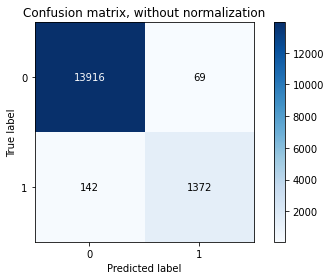

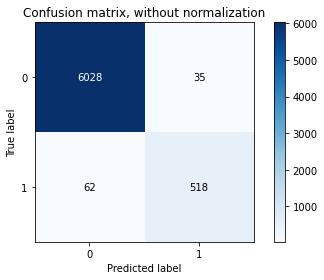

In [16]:
p = 0.5
print('#'*20)
print('train')
cal(y,oof_lgb,p=p)
print('#'*20)
print('test')
cal(y_test.values,predictions_lgb,p=p)

print('#'*20)
print('train confusion matrix')
class_names = np.array(["0","1"])
plot_confusion_matrix(y, [1 if i >= p else 0 for i in oof_lgb], classes=class_names, normalize=False) 

print('#'*20)
print('test confusion matrix')
class_names = np.array(["0","1"])
plot_confusion_matrix(y_test.values, [1 if i >= p else 0 for i in predictions_lgb], classes=class_names, normalize=False)

print('#'*20)
print('positive number in application data:')
print(np.sum([1 if f>=p else 0 for f in valid_lgb.mean(axis=1).tolist()]))

train_data['prob'] = train_lgb.mean(axis=1)
train_data['pred'] = [1 if f>=p else 0 for f in train_lgb.mean(axis=1).tolist()]

valid['prob'] = valid_lgb.mean(axis=1)
valid['pred'] = [1 if f>=p else 0 for f in valid_lgb.mean(axis=1).tolist()]

In [17]:
cols_output = features_slc + ['label','prob','pred']
train_data[cols_output].to_excel('../res/training data_label.xlsx', index=False)
valid[cols_output].to_excel('../res/application data_label.xlsx', index=False)
df_feature_importance.sort_values(by='gain', ascending=False).to_excel('../res/feature importance.xlsx', index=False)

In [18]:
print('#'*20)
print('feature importance：')
print(df_feature_importance.sort_values(by='gain', ascending=False).head(10))

####################
feature importance：
     features   gain
3       TM/YB  233.2
1       YB/LU  230.2
4     Y/LA/TB  197.0
0   CE**EU*EU  188.6
6        TH/U  188.6
8       ER/TM  188.2
31   YB/LU/HF  180.6
26   NB/LU/TA  175.4
13      TB/DY  173.0
5       ER/YB  172.2


In [19]:
df_index = pd.DataFrame()
df_index['feature'] = features_slc

In [20]:
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
print('#'*20)
print('variable_ks')
ks_lst = []
for col in features_slc:
    ks=ks_calc_auc(train_data,[col], ['label'])
#     print('{} ks :{}'.format(col,ks))
    ks_lst.append(ks)
df_index['ks'] = ks_lst
df_index.to_excel('../res/ks.xlsx', index=False)

####################
variable_ks
